# Code to simulate LMG Model
We have the following Hamiltonian
\begin{align}
H&=-\frac{J}{N}\sum_{i<j}\gamma_z \sigma_{i}^{z}\sigma_{j}^{z}+\gamma_y \sigma_{i}^{y}\sigma_{j}^{y}-\Gamma\sum_{i}\sigma_{i}^{x}
\end{align}
This reduces to (See ~/Dropbox/Research_Projects_Current/LMG_quench/LMG_quench.lyx),
\begin{equation}
\frac{J}{2}\left(\gamma_{z}-\frac{\gamma_{y}N}{2}\right)-\frac{J\left(2\gamma_{z}-\gamma_{y}\right)}{N}S_{z}^{2}+\frac{J\gamma_{y}}{2N}\left(S_{+}^{2}+S_{-}^{2}\right)-\Gamma\left(S_{+}+S_{-}\right)
\end{equation}
with the matrix elements,
\begin{align}
\left\langle S=\frac{N}{2},M\right|H\left|S=\frac{N}{2},M^{\prime}\right\rangle 	=&\delta_{MM^{\prime}}\left[\frac{J}{2}\left(\gamma_{z}+\gamma_{y}\left(1-\frac{2S\left(S+1\right)}{N}\right)\right)-\frac{J\left(2\gamma_{z}-\gamma_{y}\right)}{N}M^{2}\right]+ \nonumber \\
	&\ \ \ \delta_{MM^{\prime}-2}\left[\frac{J\gamma_{y}}{2N}\sqrt{\left(S\left(S+1\right)-\left(M+2\right)\left(M+1\right)\right)\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}+2}\left[\frac{J\gamma_{y}}{2N}\sqrt{\left(S\left(S+1\right)-\left(M-2\right)\left(M-1\right)\right)\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}-1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
	&\ \ \ \delta_{MM^{\prime}+1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]
\end{align}

In [2]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
from latex_envs.latex_envs import figcaption
#import chardet
import os
import mod_LMG_v1 as LMG
import h5py
#for Latex font on figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Roman']})
rc('text', usetex=True)

/home/paraj/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Ground state phase diagram 
We look at the ground state phase diagram of the postquench Hamiltonian

In [163]:
#calculate magnetization as a function of magnetic field
#tests magnetizationz2
Γarr=np.linspace(0.,2,40)
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,2000,1000)])#choose even
magsqlist=np.ones([np.size(Γarr),1])
criticalmagsqlist=np.ones([np.size(Larr),1])

for p in range(np.size(Γarr)):
    L=100
    print(p, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1,γy=0.5,Γ=Γarr[p]) 
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    magsqlist[p]=LMG.magnetizationϕ2(GState,paramvals,1,0)+LMG.magnetizationϕ2(GState,paramvals,0,1)
for q in range(np.size(Larr)):
    L=Larr[q]
    print(q, end='\r', flush=True)
    paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=0,γy=1,Γ=1) 
    Ham=LMG.LMG_generateHam(paramvals)
    GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
    GState=vec[:,0]
    criticalmagsqlist[q]=LMG.magnetizationϕ2(GState,paramvals,1,0)+LMG.magnetizationϕ2(GState,paramvals,0,1)
criticalΓ=paramvals.J*max(paramvals.γz,paramvals.γy)

In [164]:
#fitting to system size dependence
#linear fit to data
logy=np.log10(criticalmagsqlist)
logx=np.log10(Larr)
m1,b1 = np.polyfit(logx,logy, 1)

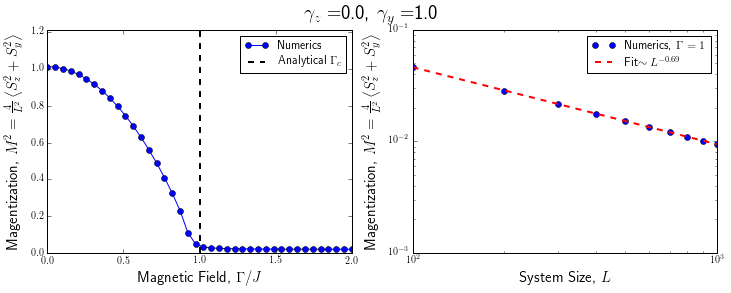

In [165]:
#plotting
plt.figure(figsize=(12,4))
plt.suptitle("$\\gamma_z=$"+str(paramvals.γz)+", $\\gamma_y=$"+str(paramvals.γy),fontsize=20)
plt.subplot(1,2,1)
plt.plot(Γarr, magsqlist,'-o',label='Numerics')
plt.axvline(criticalΓ,linestyle='dashed',color= 'black',label='Analytical $\\Gamma_c$',linewidth=2)
plt.ylim([0,np.max(magsqlist)+0.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization, $M^2=\\frac{4}{L^2}\\left\\langle S_z^2+S_y^2\\right\\rangle$",fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.loglog(Larr,criticalmagsqlist,'o',label='Numerics, $\Gamma=1$' % Γarr[p])
plt.loglog(Larr,(10**b1)*(Larr)**m1,'--',linewidth=2,color='red',label='Fit$\\sim L^{%0.2f}$' % m1)
plt.xlabel("System Size, $L$",fontsize=15)
plt.ylabel("Magentization, $M^2=\\frac{4}{L^2}\\left\\langle S_z^2+S_y^2\\right\\rangle$",fontsize=15)
plt.legend()
figcaption("(a)Magnetization as a function of magnetic field with dashed line showing analytical expectation (b) $L$ dependence of magnetization at the critical point. Seems like it agrees with $M^2\sim N^{-2/3}$")

## Phase diagram as a function of the anisotropy.
We would like to recover the phase diagram as a function of the anisotropy parameter $\gamma$. The attempt is to reproduce the Fig.1 in PHYSICAL REVIEW E 78, 021106 (2008). There are four phases depending on the density of states. We would like to obtain for following parameters. In the paper, the Hamiltonian is defined as,
\begin{equation}
H=-\frac{1}{N}(\gamma_x S_x^2+\gamma_yS_y^2)-hS_z
\end{equation}
The different phases parameterized by ($\gamma_x,\gamma_y,h$) are identified as
$I\rightarrow(1/2,1/3,1)
II\rightarrow (2,1/2,1)
III\rightarrow (5,-3,1)
IV \rightarrow(5,3,1)$.

Translating to my notation, $\gamma_x\rightarrow 2J$, $\gamma_y\rightarrow 2J\gamma$, $h\rightarrow 2\Gamma$. And the energies are ofset by a constant $E_{PhysRevE}=E-\frac{J}{2}(1+\gamma)$. So we have the following phases,
\begin{enumerate}
\item $I\rightarrow (J=1/4,\gamma=2/3,\Gamma=1/2)$
\item $II\rightarrow (J=1,\gamma=1/4,\Gamma=1/2)$
\item $III\rightarrow (J=5/2,\gamma=-3/5,\Gamma=1/2)$
\item $IV\rightarrow (J=5/2,\gamma=3/5,\Gamma=1/2)$
\end{enumerate}

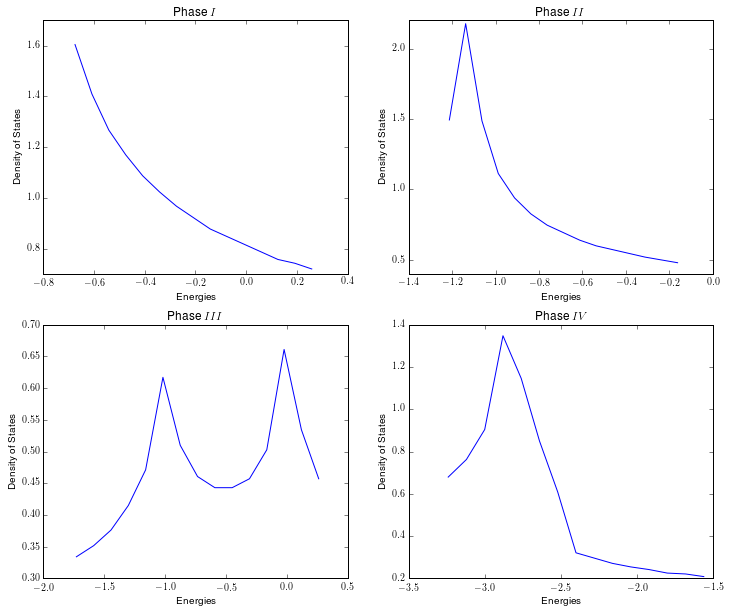

In [17]:
L=2000
plt.figure(figsize=[12,10])
#####Phase I
plt.subplot(2,2,1)
paramvals=LMG.Ham_params(N=L,S=L/2,J=1/4,γ=2/3,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/8*(1+2/3)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $I$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase II
plt.subplot(2,2,2)
paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γ=1/4,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-1/2*(1+1/4)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $II$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase III
plt.subplot(2,2,3)
paramvals=LMG.Ham_params(N=L,S=L/2,J=5/2,γ=-3/5,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1-3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $III$')
plt.xlabel('Energies')
plt.ylabel('Density of States')
#####Phase IV
plt.subplot(2,2,4)
paramvals=LMG.Ham_params(N=L,S=L/2,J=5/2,γ=3/5,Γ=1/2)
Ham=LMG.LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
counts,bin_edges = np.histogram(np.real(Energies), bins=15)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
energypersite=bincenters/L-5/4*(1+3/5)
plt.plot(energypersite,counts/(np.sum(counts)*np.abs(energypersite[1]-energypersite[2])),'-')
plt.title('Phase $IV$')
plt.xlabel('Energies')
plt.ylabel('Density of States')

x


\subsection{Quench Protocol-I : Critical quench}
We start with an initial state and initial Hamiltonian,
\begin{align}
|\psi_{0}\rangle&=\text{Ground state of H_0} \\
\end{align}
In order to translate to notation in Mohammad's calculation and (Phys. Rev. B 74, 144423) we need to make a transformation that is done in LMG_quench.lyx.  

For the numerics we choose the parameters for the critical quench. We have the data for the following quenches
\begin{itemize}
\item $H_0$ is critical. $H_0\rightarrow \{ J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=1\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=0$, $\gamma_y=1$ $\Gamma=1\}$.
\item $H_0$ is critical. $H_0\rightarrow \{J_0=1$, $\gamma_{0z}=1$, $\gamma_{0y}=0$, $\Gamma=1\}$ to $H_f\rightarrow \{J=1$, $\gamma_z=1$, $\gamma_y=0.5$ $\Gamma=1\}$.
\end{itemize}


## A. Obtain time dependence of $\langle S_z^2+S_y^2\rangle $

In this section we focus on a particular system size, (say $L=100$) and plot the time dependence of the spin on th $y-z$ plane.



In [167]:
L=5000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.5,Γ=1.)
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [168]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    with h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]

Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_20.0]_from_L_5000,S_2500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_5000,S_2500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5.hdf5
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_20.0]_from_L_5000,S_2500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_5000,S_2500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.5.hdf5


In [169]:
Syz2=Sz2arr+Sy2arr

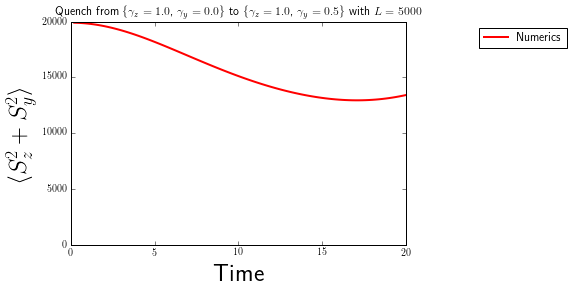

In [170]:
#plotting
plt.plot(tarr,Syz2,'-',color='red',linewidth=2,label='Numerics')
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_z^2+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,20)
plt.ylim(0,np.max(Syz2)+100)
plt.legend(numpoints=1,bbox_to_anchor=(1.5,1))
plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))
figcaption("Time-dependence of the total spin for a system size $L=1000$ with the quench parameters shown in the figure. ")

# B. $L$ dependence of the time-averaged-$\langle S_z^2+S_y^2\rangle$
Here we discuss the dependence on system size of the time-averaged correlator. Recall that we are quenching from one critical point to another. In this case, according to Mohammad's calculation using the Holstein Primakoff, it is expected that, for large $N$
\begin{align}
\overline{\langle(S_{{\rm tot}}^{z}(t))^{2}\rangle}\sim L^{4/3}
\end{align}

## Figure-1: Quench to the critical point. $H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=0$,$\gamma_{fy}=1$, $\Gamma_f=1\}$

In [171]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,10000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [172]:
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.5,Γ=1.)
    #load Sz^2 data
    filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)       
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

L=800 data doesn't exist!
L=2000 data doesn't exist!
L=6000 data doesn't exist!
L=7000 data doesn't exist!
L=8000 data doesn't exist!
L=9000 data doesn't exist!


In [173]:
##numerical formulae for time-averaged value
Sϕtavg=np.mean(Sϕ2vals_nonzero, axis=0)
#linear fit to data
logy=np.log10(np.divide(Sϕtavg,Larr_nonzero**2))
logx=np.log10(Larr_nonzero)
m1,b1 = np.polyfit(logx,logy, 1)
#plt.plot(logx,logy,'o')
#plt.plot(logx,m1*logx+b1,'--')

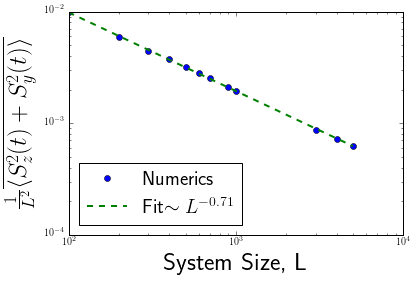

In [174]:
#Plot average magnetization as a function of L

#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr_nonzero,np.divide(Sϕtavg,Larr_nonzero**2),'o',label='Numerics')
plt.loglog(Larr_nonzero,(10**b1)*(Larr_nonzero)**m1,'--',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % m1)
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)+ S_y^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
#plt.title('Quench from  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$ to  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$'%{paramvals0.γz,paramvals0.γy.paramvalsf.γz,paramvalsf.γy},fontsize=25)
plt.legend(loc=3,numpoints=1,fontsize=20)
figcaption("Quench to the critical point. It is clear that the scaling with system size is $\sim N^{-1/3}$" )

\subsection{Appendix: Quench Protocol: Sanity Checks}
We perform the following sanity check. We donot do a quench. Then there should be no time- depedence of $\langle S_z^2+S_y^2\rangle $ and the finite size depednece of long time magnetization should be identical to that of the ground state.

## Appendix Figure-2: No quench Time dependence of observables
$H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=1$,$\gamma_{fy}=0$, $\Gamma_f=1\}$


In [139]:
L=1000 #Set system size.
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [140]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    with h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]

Loading files:
 /home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_1.0_Ay_0.0_[0_0.2_20.0]_from_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/Sϕ2t_Az_0.0_Ay_1.0_[0_0.2_20.0]_from_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0_to_L_1000,S_500.0,J_1.0,Γ_1.0,γz_1.0,γy_0.0.hdf5


In [ ]:
#run this or load file
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
#load Sz^2 data
filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
#load Sy^2 data
filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
    print("Data doesn't exist!")
else:
    print("Loading files:\n "+filename1+"\n"+filename2)
    Syz2=Sz2arr+Sy2arrith h5py.File(filename1, "r") as f:
        Sz2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]
    with h5py.File(filename2, "r") as f:
        Sy2arr= f["Sϕ2arr"][...]
        InitState=f["InitState"][...]

In [141]:
Syz2=Sz2arr+Sy2arr

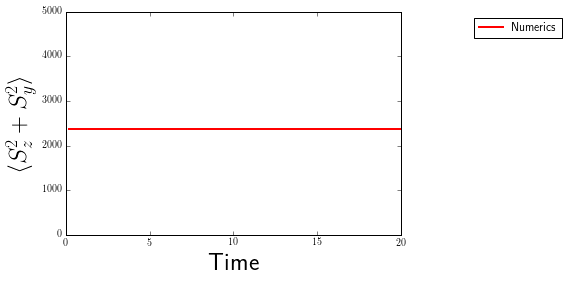

In [150]:
#plotting
plt.plot(tarr,Syz2,'-',color='red',linewidth=2,label='Numerics')
#plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
#plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_z^2+S_y^2\\rangle$",fontsize=25)
plt.xlim(0,20)
plt.ylim(0,5000)
plt.legend(numpoints=1,bbox_to_anchor=(1.5,1))
#plt.title('Quench from \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} to \\{$\\gamma_z= %.1f $, $\\gamma_{y}= %.1f $\\} with $L=%d$'%(paramvals0.γz,paramvals0.γy, paramvalsf.γz,paramvalsf.γy,L))

figcaption("Time-dependence of the total spin for a system size $L=1000$ when there is no quench. Note that if we zoom in , there is an oscillation with magnitude $\sim 0.03$ ")

## Appendix Figure-2: No quench, Size dependence
$H_0\equiv \{J_0=1$, $\gamma_{0z}=1$,$\gamma_{0y}=0$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$,  $\gamma_{fz}=1$,$\gamma_{fy}=0$, $\Gamma_f=1\}$


In [155]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,10000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [156]:
directory1='data/Sϕ2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sϕ2t/'
Sϕ2vals=np.zeros((Nsteps,np.size(Larr)))
deletelist=np.array([],dtype=int)
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.,γz=1.,γy=0.,Γ=1.)
    #load Sz^2 data
    filename1=directory2+'Sϕ2t_Az_1.0_Ay_0.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #load Sy^2 data
    filename2=directory2+'Sϕ2t_Az_0.0_Ay_1.0_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    if (not os.path.exists(filename1)) or (not os.path.exists(filename2)):
        print("L="+str(L)+" data doesn't exist!")
        deletelist=np.append(deletelist,int(p))
    else:
        #print("Loading files:\n "+filename1+"\n"+filename2)
        with h5py.File(filename1, "r") as f:
            Sz2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        with h5py.File(filename2, "r") as f:
            Sy2arr= f["Sϕ2arr"][...]
            InitState=f["InitState"][...]
        Sϕ2vals[:,p]=Sz2arr+Sy2arr
Sϕ2vals_nonzero=np.delete(Sϕ2vals,deletelist,axis=1)       
Larr_nonzero=np.delete(Larr,deletelist,axis=0)

L=800 data doesn't exist!
L=2000 data doesn't exist!
L=5000 data doesn't exist!
L=6000 data doesn't exist!
L=7000 data doesn't exist!
L=8000 data doesn't exist!
L=9000 data doesn't exist!


In [157]:
##numerical formulae for time-averaged value
Sϕtavg=np.mean(Sϕ2vals_nonzero, axis=0)
#linear fit to data
logy=np.log10(np.divide(Sϕtavg,Larr_nonzero**2))
logx=np.log10(Larr_nonzero)
m1,b1 = np.polyfit(logx,logy, 1)
#plt.plot(logx,logy,'o')
#plt.plot(logx,m1*logx+b1,'--')

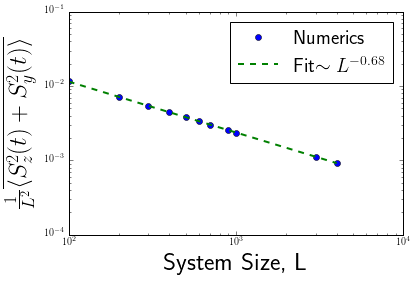

In [158]:
#Plot average magnetization as a function of L

#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr_nonzero,np.divide(Sϕtavg,Larr_nonzero**2),'o',label='Numerics')
plt.loglog(Larr_nonzero,(10**b1)*(Larr_nonzero)**m1,'--',linewidth=2,label='Fit$\\sim L^{%0.2f}$' % m1)
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)+ S_y^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
#plt.title('Quench from  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$ to  $\gamma_{z}=%0.1f$,$\gamma_{y}=%0.1f$'%{paramvals0.γz,paramvals0.γy.paramvalsf.γz,paramvalsf.γy},fontsize=25)
plt.legend(loc=1,numpoints=1,fontsize=20)
figcaption("Quench to the same initial parameters $\{\gamma_{0z}=1,\gamma_{0y}=0\}=\{\gamma_{fz},\gamma_{fy}\}$. It is clear that the scaling with system size is $\sim N^{-2/3}$" )